In [173]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)


In [174]:
customers = pd.read_csv("C:/Users/HP/Desktop/power bi/classic_models_dataset/customers.csv")
employees = pd.read_csv("C:/Users/HP/Desktop/power bi/classic_models_dataset/employees.csv")
offices = pd.read_csv("C:/Users/HP/Desktop/power bi/classic_models_dataset/offices.csv")
order_details = pd.read_csv("C:/Users/HP/Desktop/power bi/classic_models_dataset/order details.csv")
payments = pd.read_csv("C:/Users/HP/Desktop/power bi/classic_models_dataset/payments.csv")
products = pd.read_csv("C:/Users/HP/Desktop/power bi/classic_models_dataset/products.csv")


In [175]:
# Step 3: Merge order_details with products (for product info)
order_products = order_details.merge(products, on="productCode", how="left")

In [176]:
# Aggregate per order: total order value
order_summary = order_products.groupby("orderNumber").agg({
    "quantityOrdered": "sum",
    "priceEach": "mean",
    "buyPrice": "mean",
    "productLine": lambda x: x.mode()[0] if not x.mode().empty else "Unknown"
}).reset_index()

order_summary["order_value"] = order_summary["quantityOrdered"] * order_summary["priceEach"]

In [177]:
# Step 4: Aggregate payments per customer
payment_summary = payments.groupby("customerNumber").agg({
    "amount": ["mean", "sum", "count"]
}).reset_index()
payment_summary.columns = ["customerNumber", "avg_payment", "total_payment", "num_payments"]

In [178]:
# Step 5: Merge customers with payments
customer_data = customers.merge(payment_summary, on="customerNumber", how="left")

In [179]:
# Fill missing payment info
customer_data.fillna({"avg_payment": 0, "total_payment": 0, "num_payments": 0}, inplace=True)

In [180]:
# Step 6: Create Target Variable (Late Payment)
# Rule: If avg_payment < 0.5 * creditLimit → late
customer_data["late_payment"] = np.where(
    customer_data["avg_payment"] < (0.5 * customer_data["creditLimit"]), 1, 0
)

In [181]:
# Step 7: Feature Selection
features = customer_data[["country", "creditLimit", "avg_payment", "total_payment", "num_payments"]]
target = customer_data["late_payment"]
# Encode categorical variables
features = pd.get_dummies(features, columns=["country"], drop_first=True)

In [182]:
# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [183]:
# Step 9: Train Naïve Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [184]:
# Step 10: Predictions
y_pred = nb_model.predict(X_test)
y_prob = nb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC

In [185]:
# Step 11: Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(" Naïve Bayes Model Results ")
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

 Naïve Bayes Model Results 
Accuracy: 0.76

Confusion Matrix:
 [[ 6  0]
 [ 6 13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       1.00      0.68      0.81        19

    accuracy                           0.76        25
   macro avg       0.75      0.84      0.74        25
weighted avg       0.88      0.76      0.78        25



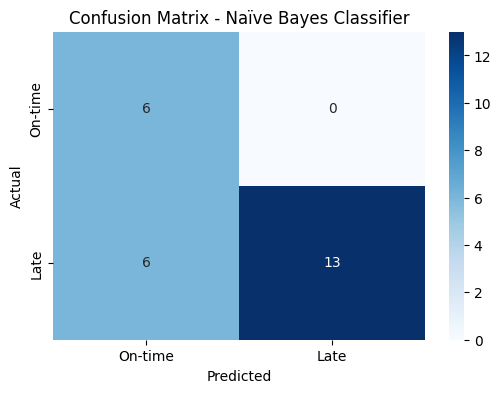

In [186]:
# Step 12: Visualize Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["On-time", "Late"], yticklabels=["On-time", "Late"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naïve Bayes Classifier")
plt.show()

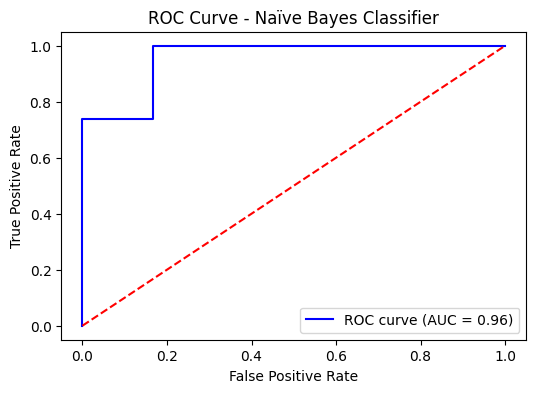

In [187]:
# Step 13: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naïve Bayes Classifier")
plt.legend(loc="lower right")
plt.show()